In [1]:
from mesa import Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent.
    '''
    def __init__(self, pos, agent_type):
        self.pos = pos
        self.type = agent_type
    def step(self):
        print("self is ", self)
        print("Inside step function. Agent type is ", self.type)

a = SchellingAgent((0,1),0)
print(a)
print(a.type)
print(a.pos)
a.step()

0
(0, 1)
self is  <__main__.SchellingAgent object at 0x10d2a3b50>
Inside step function. Agent type is  0


In [2]:
a = SchellingAgent((0,0), 1)
b = SchellingAgent((0,1), 0)

print("a ", a)
print(a.pos)
print(a.type)
a.step()

print("\n")
print("b ", b)
print(b.pos)
print(b.type)
b.step()

a  <__main__.SchellingAgent object at 0x10d2c7190>
(0, 0)
1
self is  <__main__.SchellingAgent object at 0x10d2c7190>
Inside step function. Agent type is  1


b  <__main__.SchellingAgent object at 0x10d2c7f10>
(0, 1)
0
self is  <__main__.SchellingAgent object at 0x10d2c7f10>
Inside step function. Agent type is  0


In [3]:
from mesa import Model, Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent
    '''
    def __init__(self, unique_id, pos, model, agent_type):
        '''
         Create a new Schelling agent.
         Args:
            pos: Agent initial location.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.type = agent_type

    def step(self):
        similar = 0
        neighbors = self.model.grid.neighbor_iter(self.pos)
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar += 1

        # If unhappy, move:
        if similar < self.model.homophily:
            self.model.grid.move_to_empty(self)
        else:
            self.model.happy += 1


In [4]:
class A():
    def __init__(self, param):
        print("initializing A with ", param)
        self.A_parameter = param
        self.param2 = "Another parameter"
        
class B(A):
    def __init__(self, param):
        print("B is a subclass of A")
        self.B_parameter = param

b = B(7)
print(b.param2) # produces an error since the base class hasn't been initialized

B is a subclass of A


AttributeError: 'B' object has no attribute 'param2'

In [5]:
# 1. The first approach is to explicitly reference the base class __init__ function
class A():
    def __init__(self, param):
        print("Initializing A with ", param)
        self.A_parameter = param
        self.param2 = "Another parameter"
        
class B(A):
    def __init__(self, param):
        print("Initializing B with ", param)
        self.B_parameter = param
        A.__init__(self, param)

b = B(42)
print(f"b.param2 is {b.param2}") # now b can access the base class attributes
print(f"b.B_parameter is {b.B_parameter}")
print(f"b.A_parameter is {b.A_parameter}")



Initializing B with  42
Initializing A with  42
b.param2 is Another parameter
b.B_parameter is 42
b.A_parameter is 42


In [6]:
# 2. The second (preferable) approach is to use the builtin super()

class A():
    def __init__(self, param):
        print("Initializing A with ", param)
        self.A_parameter = param
        self.param2 = "Another parameter"

class B(A):
    def __init__(self, param):
        print("Initializing B with ", param)
        self.B_parameter = param
        super().__init__(param)

b = B(7)
print(f"b.param2 is {b.param2}") # now b can access the base class attributes
print(f"b.B_parameter is {b.B_parameter}")
print(f"b.A_parameter is {b.A_parameter}")



Initializing B with 

 7
Initializing A with  7
b.param2 is Another parameter
b.B_parameter is 7
b.A_parameter is 7


In [7]:
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import random 

class SchellingModel(Model):
    '''
    Model class for the Schelling segregation model.
    '''
    def __init__(self, height, width, density, minority_percent, homophily):
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_percent = minority_percent
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        self.datacollector = DataCollector(
            {"happy": lambda m: m.happy},  # Model-level count of happy agents
            # For testing purposes, agent's individual x and y
            {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})
        self.running = True
        # Set up agents
        agent_id = 0
        for cell in self.grid.coord_iter():
            #print(cell)
            _,x,y = cell
            if random.random() < self.density:
                if random.random() < self.minority_percent:
                    agent_type = 1
                else:
                    agent_type = 0
                agent = SchellingAgent(agent_id, (x, y), self, agent_type)
                agent_id += 1
                self.grid.position_agent(agent, x=x, y=y)
                self.schedule.add(agent)
        
    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        self.happy = 0  # Reset counter of happy agents
        self.schedule.step()
        self.datacollector.collect(self)
        if self.happy == self.schedule.get_agent_count():
            self.running = False


In [8]:
height, width = 10, 10
density = 0.1
minority_percent = 0.2
homophily = 4
model = SchellingModel(height, width, density, minority_percent, homophily)
print("Display the first 5 agents:\n")
for a in model.schedule.agents[0:5]: 
    print(a)
    print("type is ", a.type)
    print(f"pos is {a.pos}")
    print(f"unique id is {a.unique_id}\n")


Display the first 5 agents:

type is  1
pos is (0, 3)
unique id is 0

type is  0
pos is (0, 8)
unique id is 1

type is  0
pos is (4, 3)
unique id is 2

type is  0
pos is (5, 1)
unique id is 3

type is  0
pos is (5, 2)
unique id is 4



In [9]:
# execute one round of the models
model.step()

# some positions should change
for a in model.schedule.agents[0:5]: 
    print(a)
    print("type is ", a.type)
    print(f"pos is {a.pos}")
    print(f"unique id is {a.unique_id}")
    print(f"model.happy = {model.happy}\n")


type is  1
pos is (1, 9)
unique id is 0
model.happy = 0

type is  0
pos is (1, 0)
unique id is 1
model.happy = 0

type is  0
pos is (5, 3)
unique id is 2
model.happy = 0

type is  0
pos is (3, 4)
unique id is 3
model.happy = 0

type is  0
pos is (9, 0)
unique id is 4
model.happy = 0



In [10]:
# To illustrate the RandomAcitivation scheduler, note that running this
# multiple times will produce different orders of the agents

print([a.unique_id for a in model.schedule.agent_buffer(shuffled=True)])

[3, 10, 6, 8, 1, 9, 5, 7, 0, 4, 11, 2]


In [11]:
# create a simple Schelling model with a 3x3 grid
model2 = SchellingModel(3, 3, 0, 0.2, 4)

# each cell is a tuple where the first component is the agent, 
# the second component is the x position and 
# the 3rd component is the y position
for cell in model2.grid.coord_iter():
    print(cell)


(None, 0, 0)
(None, 0, 1)
(None, 0, 2)
(None, 1, 0)
(None, 1, 1)
(None, 1, 2)
(None, 2, 0)
(None, 2, 1)
(None, 2, 2)


In [12]:
a1 = SchellingAgent(0, (1, 1), model2, 0)

# initially position the agent at 1,1
model2.grid.position_agent(a1, x=1, y=1)

for cell in model2.grid.coord_iter():
    print(cell)
print(f"\na1 pos is {a1.pos}")


(None, 0, 0)
(None, 0, 1)
(None, 0, 2)
(None, 1, 0)
(<__main__.SchellingAgent object at 0x10d307820>, 1, 1)
(None, 1, 2)
(None, 2, 0)
(None, 2, 1)
(None, 2, 2)

a1 pos is (1, 1)


In [13]:

# now move a1 to an empty location
model2.grid.move_to_empty(a1)

for cell in model2.grid.coord_iter():
    print(cell)
print(f"\na1 pos is {a1.pos}")


(None, 0, 0)
(None, 0, 1)
(None, 0, 2)
(None, 1, 0)
(None, 1, 1)
(None, 1, 2)
(<__main__.SchellingAgent object at 0x10d307820>, 2, 0)
(None, 2, 1)
(None, 2, 2)

a1 pos is (2, 0)


In [14]:
model2 = SchellingModel(3, 3, 0, 0.2, 4)
model2.grid = SingleGrid(3, 3, torus=True)

a1 = SchellingAgent(1, (1, 1), model2, 0)
a2 = SchellingAgent(2, (1, 0), model2, 0)
a3 = SchellingAgent(3, (0, 0), model2, 0)
a4 = SchellingAgent(4, (2, 2), model2, 0)

model2.grid.position_agent(a1, x=1, y=1)
model2.grid.position_agent(a2, x=1, y=0)
model2.grid.position_agent(a3, x=0, y=0)
model2.grid.position_agent(a4, x=2, y=2)

print("The neighbors of a1 are: ")
for n in model2.grid.neighbor_iter(a1.pos):
    print(f"a{n.unique_id} at {n.pos}")
    
print("The neighbors of a3 are: ")
for n in model2.grid.neighbor_iter(a3.pos):
    print(f"a{n.unique_id} at {n.pos}")

The neighbors of a1 are: 
a3 at (0, 0)
a2 at (1, 0)
a4 at (2, 2)
The neighbors of a3 are: 
a4 at (2, 2)
a2 at (1, 0)
a1 at (1, 1)


In [15]:
height, width = 50, 50
density = 0.8
minority_percent = 0.3
homophily = 4
model = SchellingModel(height, width, density, minority_percent, homophily)

while model.running and model.schedule.steps < 1000:
    model.step()
print(f"The model ran for {model.schedule.steps} steps") # Show how many steps have actually run

The model ran for 305 steps


In [16]:
def f1(p):
    return p + 2

print(f1(2))

f2 = lambda p: p + 2

print(f2(2))

4
4


In [17]:
import pandas as pd 

data = {
    "var1": [1, 2, 3, 4, 5], 
    "var2": ["a", "b", "c", "d", "e"],
    "var3": [1, None, "a", 2.0, "c"]
}

df = pd.DataFrame(data)

df

,var1,var2,var3
0,1,a,1
1,2,b,None
2,3,c,a
3,4,d,2.0
4,5,e,c


In [18]:
model_out = model.datacollector.get_model_vars_dataframe()
model_out

,happy
0,1159
1,1395
2,1563
3,1701
4,1755
...,...
300,2008
301,2008
302,2008
303,2008


In [19]:
# use describe() to get basic statistics about the data
model_out.describe()


,happy
count,305.000000
mean,1987.636066
std,72.919354
min,1159.000000
25%,1993.000000
50%,2006.000000
75%,2007.000000
max,2009.000000


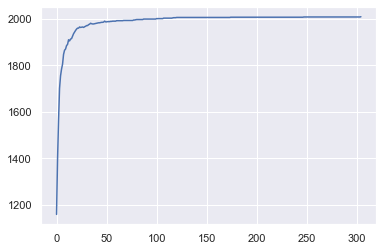

In [20]:
import seaborn as sns
sns.set()

model_out.happy.plot();

In [21]:
agent_out = model.datacollector.get_agent_vars_dataframe()
agent_out.head()

x   y
Step AgentID        
1    0        35  46
     1         0   1
     2         0   2
     3        40   8
     4         0   7

In [22]:
from mesa.batchrunner import BatchRunner

def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

In [23]:
variable_params = {"homophily": range(1,9)}
fixed_params =  {"height": 10, "width": 10, "density": 0.8, "minority_percent": 0.2} 
model_reporters = {"Segregated_Agents": get_segregation}
param_sweep = BatchRunner(SchellingModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=200, 
                          model_reporters=model_reporters, 
                          display_progress=False)

In [24]:
param_sweep.run_all()

In [25]:
df = param_sweep.get_model_vars_dataframe()
df

,homophily,Run,Segregated_Agents,height,width,density,minority_percent
0,1,0,0.340909,10,10,0.8,0.2
1,1,1,0.250000,10,10,0.8,0.2
2,1,2,0.450000,10,10,0.8,0.2
3,1,3,0.466667,10,10,0.8,0.2
4,1,4,0.273810,10,10,0.8,0.2
...,...,...,...,...,...,...,...
75,8,75,0.259259,10,10,0.8,0.2
76,8,76,0.068182,10,10,0.8,0.2
77,8,77,0.512821,10,10,0.8,0.2
78,8,78,0.129870,10,10,0.8,0.2


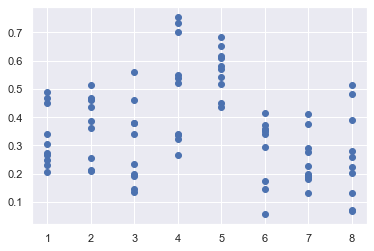

In [26]:
import matplotlib.pyplot as plt

plt.scatter(df.homophily, df.Segregated_Agents)
plt.grid(True)